## Stacked Regressions to predict House Prices
https://www.kaggle.com/coldestlin/stacked-regressions-top-4-on-leaderboard

In [17]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10, 6)  # set default pic size

import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')

from scipy import stats
from scipy.stats import norm, skew

pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x))  # limit floats

In [5]:
# files downloaed from kaggle
train = pd.read_csv('/data/tutorial/kaggle-house-price/train.csv')
test = pd.read_csv('/data/tutorial/kaggle-house-price/test.csv')
path_result = '/data/tutorial/kaggle-house-price/export_result.csv'

In [7]:
print(train.shape, test.shape)
train.head(2)

(1460, 81) (1459, 80)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.000,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.000,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500


In [9]:
train_id = train['Id']
test_id = test['Id']

train.drop('Id', axis=1, inplace=True)
test.drop('Id', axis=1, inplace=True)
train.shape, test.shape

((1460, 80), (1459, 79))

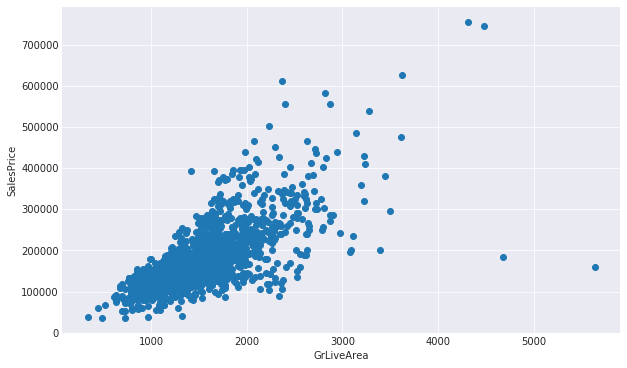

In [18]:
fig, ax = plt.subplots()
ax.scatter(x=train['GrLivArea'], y=train['SalePrice'])

plt.xlabel('GrLiveArea')
plt.ylabel('SalesPrice')
plt.show()

(1458, 80)


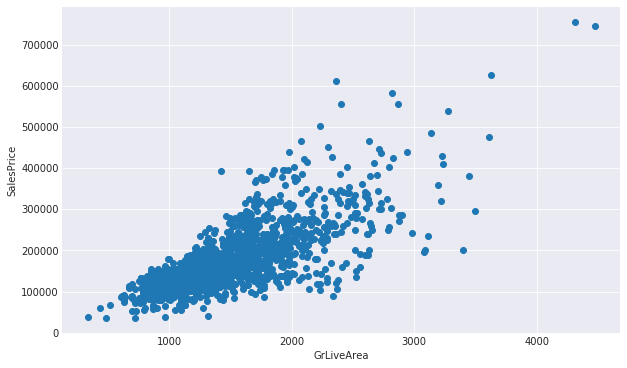

In [20]:
# delete outliers

train = train.drop(train[(train['GrLivArea']>4000) & (train['SalePrice']<300000)].index)
print(train.shape)

fig, ax = plt.subplots()
ax.scatter(x=train['GrLivArea'], y=train['SalePrice'])

plt.xlabel('GrLiveArea')
plt.ylabel('SalesPrice')
plt.show()

/home/zhlin/.pyenv/versions/3.6.2/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


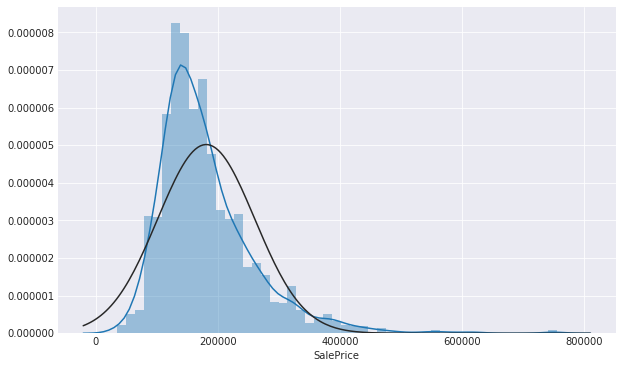

In [25]:
sns.distplot(train['SalePrice'], fit=norm)


In [30]:
mu, sigma = norm.fit(train['SalePrice'])
print('mu = {:.2f} and sigma ={:.2f}'.format(mu, sigma))
norm.fit?

mu = 180932.92 and sigma =79467.79



/home/zhlin/.pyenv/versions/3.6.2/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


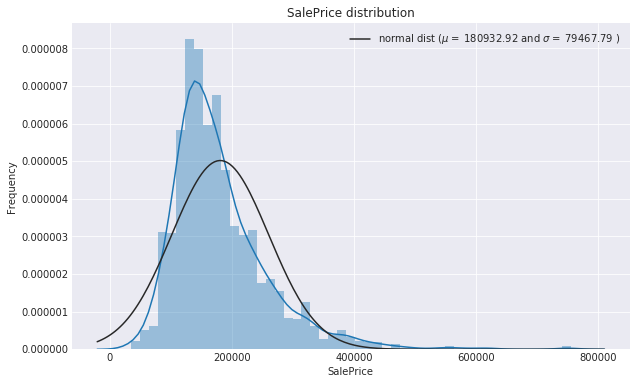

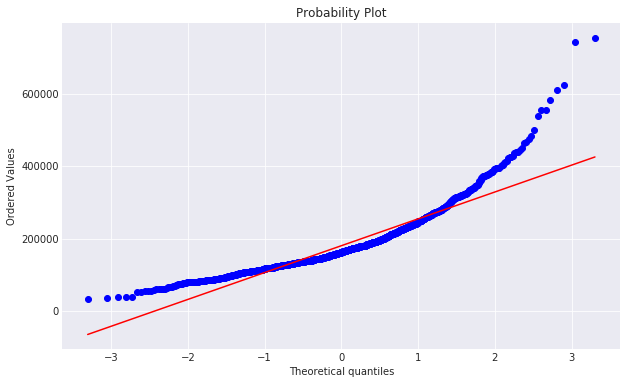

In [38]:
# 画图细节仍不清楚。。。

sns.distplot(train['SalePrice'] , fit=norm);

plt.legend(['normal dist ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)
plt.show()

/home/zhlin/.pyenv/versions/3.6.2/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


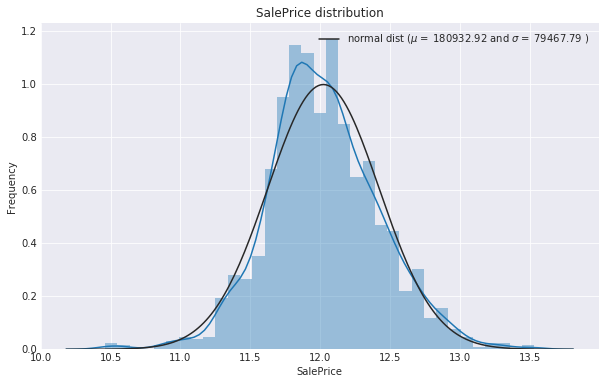

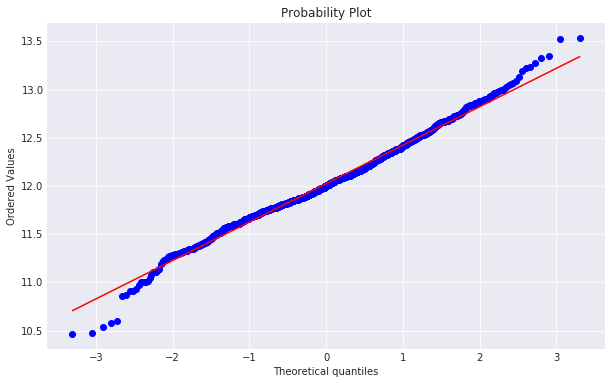

In [40]:
# log transform to adjust the skew 

train['SalePrice'] = np.log1p(train['SalePrice'])

sns.distplot(train['SalePrice'], fit=norm)

plt.legend(['normal dist ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)
plt.show()

### Features engineering

In [45]:
ntrain = train.shape[0]
ntest = test.shape[0]

y_train = train.SalePrice.values
all_data = pd.concat((train, test)).reset_index(drop=True)
all_data.drop(['SalePrice'], axis=1, inplace=True)
print('all data shape: ', all_data.shape)
all_data.head(2)

all data shape:  (2917, 79)


/home/zhlin/.pyenv/versions/3.6.2/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """


,1stFlrSF,2ndFlrSF,3SsnPorch,Alley,BedroomAbvGr,BldgType,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,...,SaleType,ScreenPorch,Street,TotRmsAbvGrd,TotalBsmtSF,Utilities,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold
0,856,854,0,NaN,3,1Fam,TA,No,706.000,0.000,...,WD,0,Pave,8,856.000,AllPub,0,2003,2003,2008
1,1262,0,0,NaN,3,1Fam,TA,Gd,978.000,0.000,...,WD,0,Pave,6,1262.000,AllPub,298,1976,1976,2007


In [54]:
# missing data 

all_data_na = all_data.isnull().sum() / len(all_data) * 100  # percent
print("all data na shape", all_data_na.shape)
print('all data na\n', all_data_na.sort_values(ascending=False)[:10])

all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio': all_data_na})
print("all data na shape filter", all_data_na.shape)
missing_data.head(10)

all data na shape (79,)
all data na
 PoolQC         99.691
MiscFeature    96.400
Alley          93.212
Fence          80.425
FireplaceQu    48.680
LotFrontage    16.661
GarageFinish    5.451
GarageQual      5.451
GarageYrBlt     5.451
GarageCond      5.451
dtype: float64
all data na shape filter (30,)


,Missing Ratio
PoolQC,99.691
MiscFeature,96.400
Alley,93.212
Fence,80.425
FireplaceQu,48.680
LotFrontage,16.661
GarageQual,5.451
GarageCond,5.451
GarageFinish,5.451
GarageYrBlt,5.451


Text(0.5,1,'Percent Missing Data by Feature')

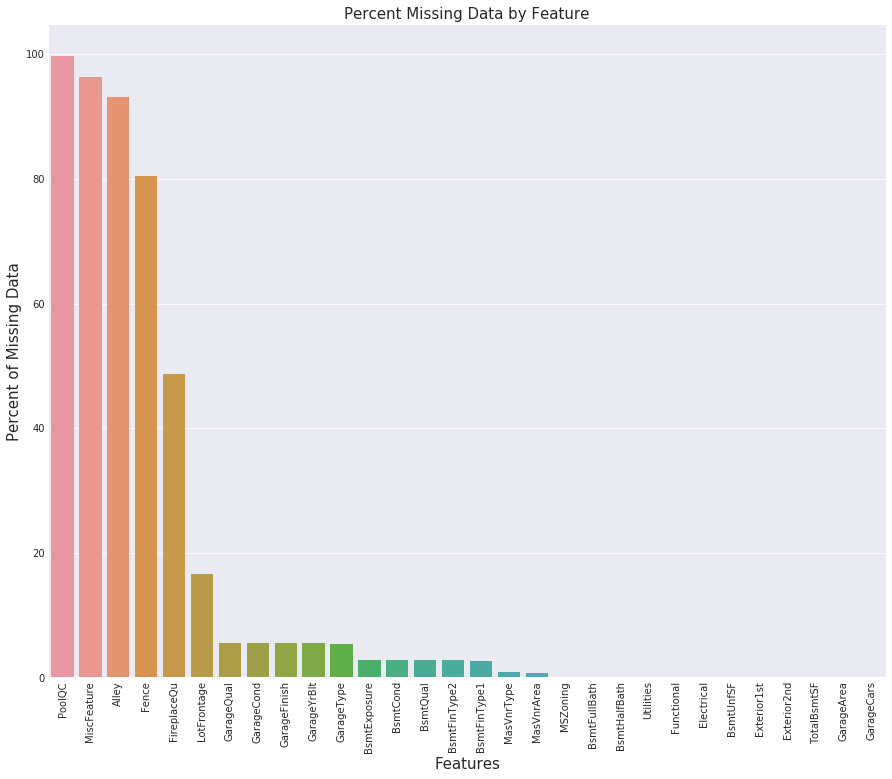

In [57]:
f, ax = plt.subplots(figsize=(15, 12))

sns.barplot(x=all_data_na.index, y=all_data_na)

plt.xticks(rotation=90)
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of Missing Data', fontsize=15)
plt.title('Percent Missing Data by Feature', fontsize=15)

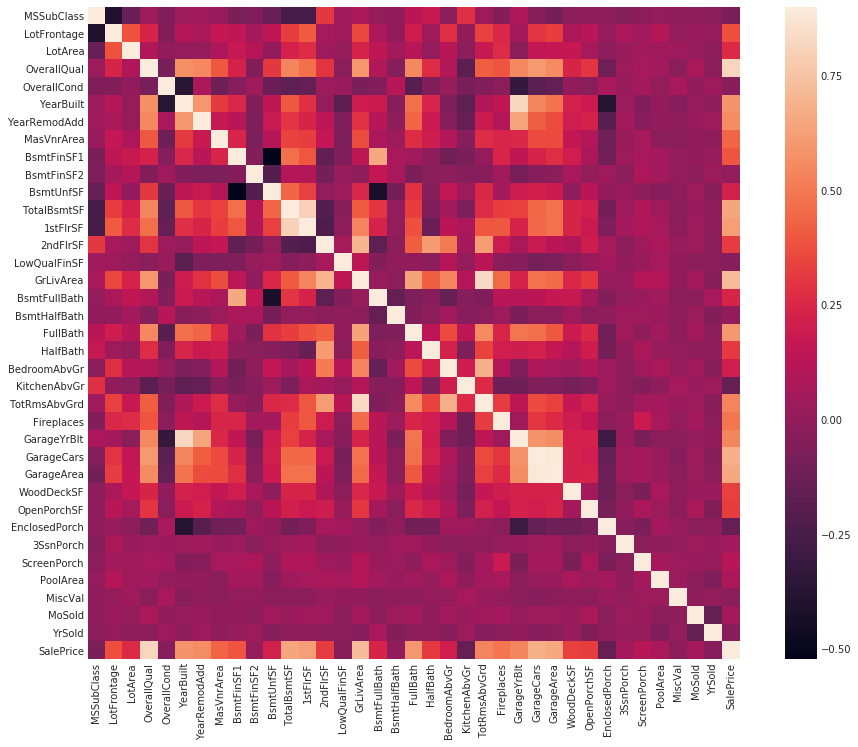

In [63]:
# data correlation

corrmat = train.corr()
plt.subplots(figsize=(16, 12))
sns.heatmap(corrmat, vmax=.9, square=True)

In [70]:
q = all_data.groupby('Neighborhood')['LotFrontage']
q.transform?

In [ ]:
all_data.groupby('Neighborhood')['LotFrontage'].transform

In [72]:
# inputing missing values

# copy paste from the tutorial
all_data["PoolQC"] = all_data["PoolQC"].fillna("None")
all_data["MiscFeature"] = all_data["MiscFeature"].fillna("None")
all_data["Alley"] = all_data["Alley"].fillna("None")
all_data["Fence"] = all_data["Fence"].fillna("None")
all_data["FireplaceQu"] = all_data["FireplaceQu"].fillna("None")

for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
    all_data[col] = all_data[col].fillna('None')

for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    all_data[col] = all_data[col].fillna(0)

for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    all_data[col] = all_data[col].fillna(0)

for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    all_data[col] = all_data[col].fillna('None')

all_data["MasVnrType"] = all_data["MasVnrType"].fillna("None")
all_data["MasVnrArea"] = all_data["MasVnrArea"].fillna(0)

all_data = all_data.drop(['Utilities'], axis=1)
all_data["Functional"] = all_data["Functional"].fillna("Typ")


#fill in missing values by the median LotFrontage of the neighborhood. Question Mark???

all_data['LotFrontage'] = all_data.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

# mode???
all_data['MSZoning'] = all_data['MSZoning'].fillna(all_data['MSZoning'].mode()[0])
all_data['Electrical'] = all_data['Electrical'].fillna(all_data['Electrical'].mode()[0])
all_data['KitchenQual'] = all_data['KitchenQual'].fillna(all_data['KitchenQual'].mode()[0])
all_data['Exterior1st'] = all_data['Exterior1st'].fillna(all_data['Exterior1st'].mode()[0])
all_data['Exterior2nd'] = all_data['Exterior2nd'].fillna(all_data['Exterior2nd'].mode()[0])

all_data['SaleType'] = all_data['SaleType'].fillna(all_data['SaleType'].mode()[0])
all_data['MSSubClass'] = all_data['MSSubClass'].fillna("None")


In [75]:
#Check remaining missing values if any 

np.sum(all_data.isnull().sum().values)

0

In [77]:
# trasform numerical variable to categorical

all_data['MSSubClass'] = all_data['MSSubClass'].apply(str)
all_data['OverallCond'] = all_data['OverallCond'].astype(str)
all_data['YrSold'] = all_data['YrSold'].astype(str)
all_data['MoSold'] = all_data['MoSold'].astype(str)


### Feature Engineering: Label Encoding

In [ ]:
all_data_copy = all_data.copy()

In [80]:
from sklearn.preprocessing import LabelEncoder

cols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 
        'YrSold', 'MoSold')

for c in cols:
    lbl = LabelEncoder()
    lbl.fit(all_data[c].values)
    all_data[c] = lbl.transform(all_data[c].values)

print('shape of all data:', all_data.shape, 'original shape', all_data_copy.shape)

shape of all data:  (2917, 78) original shape (2917, 78)


In [87]:
print('new data', all_data['FireplaceQu'].head())
print('\n')
print('original data', all_data_copy['FireplaceQu'].head())

new data 0    3
1    5
2    5
3    2
4    5
Name: FireplaceQu, dtype: int64


original data 0    None
1      TA
2      TA
3      Gd
4      TA
Name: FireplaceQu, dtype: object


In [88]:
# add new feature

all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']

### Feature Engineering: Skewed Features

In [97]:
numeric_data = all_data.select_dtypes(include=[np.number])
numeric_data.head(2)

,1stFlrSF,2ndFlrSF,3SsnPorch,Alley,BedroomAbvGr,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,BsmtFinType1,...,PoolQC,ScreenPorch,Street,TotRmsAbvGrd,TotalBsmtSF,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold,TotalSF
0,856,854,0,1,3,4,3,706.000,0.000,2,...,3,0,1,8,856.000,0,2003,2003,2,2566.000
1,1262,0,0,1,3,4,1,978.000,0.000,0,...,3,0,1,6,1262.000,298,1976,1976,1,2524.000


In [99]:
# compute skew in numeric features column by column
skewed_feats = numeric_data.apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
skewness = pd.DataFrame({'SKew': skewed_feats})
skewness.head(10)

,SKew
MiscVal,21.940
PoolArea,17.689
LotArea,13.109
LowQualFinSF,12.085
3SsnPorch,11.372
LandSlope,4.973
KitchenAbvGr,4.301
BsmtFinSF2,4.145
EnclosedPorch,4.002
ScreenPorch,3.945


In [100]:
# box cox tranformation of skewed features ???

skewness = skewness[abs(skewness) > 0.75]
print('skewed features to perform boxcox', len(skewed_feats))

from scipy.special import boxcox1p
skewed_features = skewness.index

lam = 0.15
for feat in skewed_features:
    all_data[feat] = boxcox1p(all_data[feat], lam)

skewed features to perform boxcox 59


### Feature Engineering: Dummy Categorical Features

In [102]:
# origianl data shape
all_data.shape, all_data_copy.shape

((2917, 79), (2917, 78))

In [104]:
# just convert all， 大杀器
all_data = pd.get_dummies(all_data)
print('new shape after convert categorical data to dummies', all_data.shape)

new shape after convert categorical data to dummies (2917, 220)


In [105]:
# fast resplit again
train = all_data[:ntrain]
test = all_data[ntrain:]

## Modelling Finally

In [111]:
from sklearn.linear_model import ElasticNet, Lasso, BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb